In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import cv2
import string
import matplotlib.pyplot as plt
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
df=pd.read_csv("/kaggle/input/handwritten-transcription/label.csv")
num_images=df.shape[0]
# df['label']=df['label'].apply(lambda x: str(x))
maxlength=df.label.str.len().max()
maxlength

14

In [4]:
df.head()

,Unnamed: 0,img_name,label
0,0,do@cfZDvy.png,do
1,1,character@18nwQE.png,character
2,2,forward@GVc7m3.png,forward
3,3,hand@giEJOT.png,hand
4,4,also@FBD2Tr.png,also


In [4]:
characters=set()
# lbl=str(df.loc[0]['label'])
# print(type(lbl))
# for c in lbl:
#     print(c)
for i in range(num_images):
    lbl=str(df.loc[i]['label'])
    for c in lbl:
        characters.add(c)
num_symbols=len(characters)
print(num_symbols)

35


In [5]:
num_symbols=len(characters)
symbols=""
for c in characters:
    symbols+=c
len(symbols)

35

In [6]:
symbols=sorted(list(symbols))
symbols

['A',
 'C',
 'D',
 'I',
 'M',
 'P',
 'R',
 'T',
 'V',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras import layers
char_to_num=layers.StringLookup(vocabulary=symbols, 
                                mask_token=None)
num_to_char=layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                mask_token=None, 
                                invert=True)

# tutorial and testing and learning different functions : begins

In [9]:
image="/kaggle/input/handwritten-transcription/handwritten-data/synthetic-data/character@18nwQE.png"
image=cv2.imread(image)
image=tf.image.resize_with_pad(image,target_width=256,target_height=64)


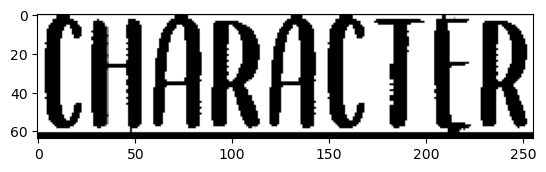

In [10]:
image.shape
plt.imshow(image)

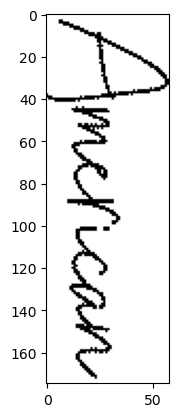

In [11]:
image2="/kaggle/input/handwritten-transcription/handwritten-data/synthetic-data/American@Do278L.png"
image2=cv2.imread(image2)
image2 = tf.transpose(image2, perm=[1, 0, 2])
image2 = tf.image.flip_left_right(image2)
plt.imshow(image2,cmap='gray')

In [12]:
lbl = char_to_num(tf.strings.unicode_split("American", input_encoding="UTF-8"))
lbl

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([ 1, 22, 14, 27, 18, 12, 10, 23])>

In [13]:
length=tf.shape(lbl)[0]
print(length)

tf.Tensor(8, shape=(), dtype=int32)


In [14]:
pad_amount=maxlength-length
lbl = tf.pad(lbl, paddings=[[0, pad_amount]], constant_values=-1)

In [15]:
lbl

<tf.Tensor: shape=(14,), dtype=int64, numpy=array([ 1, 22, 14, 27, 18, 12, 10, 23, -1, -1, -1, -1, -1, -1])>

# tutorial and testing and learning different functions : Ends

# Preparing Datset 

In [8]:
IMAGE_HEIGHT=32
IMAGE_WIDTH=128

def get_dataset(image_name,label):
    image_dir="/kaggle/input/handwritten-transcription/handwritten-data/synthetic-data/"
    image_path=image_dir+image_name
    image=tf.io.read_file(image_path)
    image=tf.io.decode_png(image,1)
    image=tf.image.resize_with_pad(image,target_width=IMAGE_WIDTH,target_height=IMAGE_HEIGHT)
    image=tf.transpose(image,perm=[1,0,2])
#     image=tf.image.random_flip_left_right(image)
    image=tf.cast(image,tf.float32)/255. # we have now an image as numpy array
    
    #vectorising labels
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) #string to chars then char to numbers
    length=tf.shape(label)[0] #length of the label , label is tensor array of shape(length,)
    pad_amount=maxlength-length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=99)
    
    return {"image":image,
            "label":label}
    

In [9]:
batch_size=16
image_names=df['img_name']
labels=df['label']
dataset = tf.data.Dataset.from_tensor_slices((image_names, labels)).map(
        get_dataset, num_parallel_calls=AUTOTUNE).batch(batch_size).cache().prefetch(AUTOTUNE)


# Visualizing Dataset

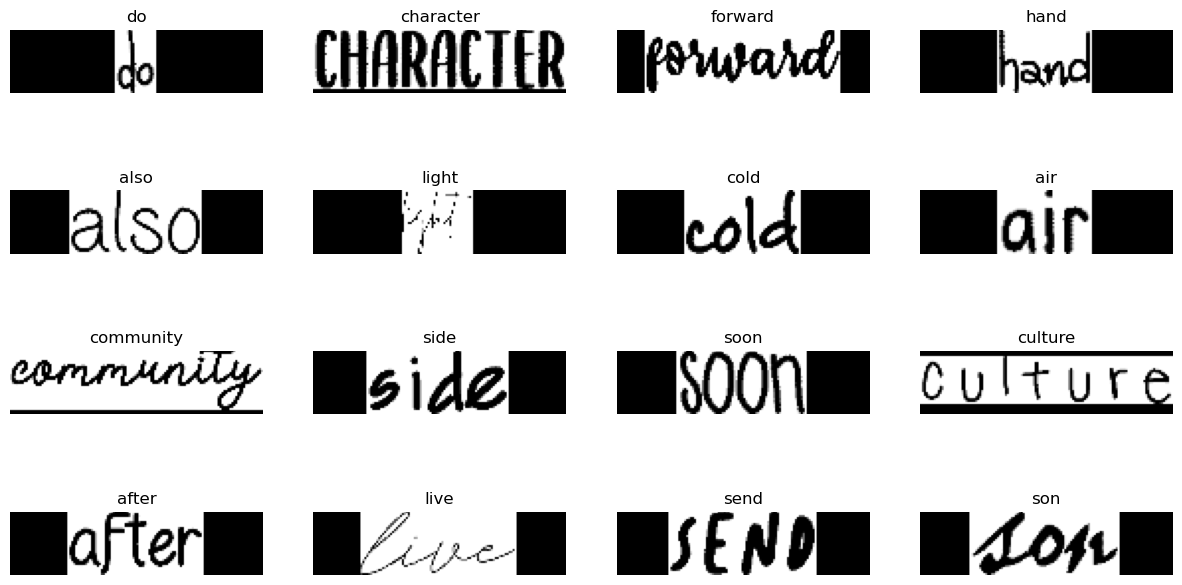

In [10]:
for data in dataset.take(1):
    images, labels = data["image"], data["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
#         img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, 99)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# splitting into valid and training

In [39]:
num_images
train_size=int(0.9*num_images)
valid_size=num_images-train_size

train=dataset.take(train_size)
valid=dataset.skip(train_size).take(valid_size)



# Model 

In [13]:
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

In [14]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [15]:
def build_model():
    input_img=keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT,1), name='image')
    labels=keras.Input(shape=(None,),name='label')
    
    x=layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(input_img)
    x=layers.MaxPool2D((2,2),name='pool1')(x)
    
    x=layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x=layers.MaxPool2D((2,2),name='pool2')(x)
    
    x=layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x=layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

    
    
    new_shape = ((IMAGE_WIDTH // 4), (IMAGE_HEIGHT // 4) * 128)
    x=layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x=layers.Dense(64,activation='relu', name='Dense1')(x)
    x=layers.Dense(128,activation='relu', name='Dense2')(x)
#     x=layers.Dense(128,activation='relu', name='Dense1')(x)

    x=layers.Dropout(0.2)(x)

    #RNNs
    x=layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)    
    x=layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    x=layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax', name='dense2')(x)
    
    output=CTCLayer(name="CTC")(labels,x)
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    model.compile(optimizer='adam', metrics['val_loss'])
    return model
    

In [16]:
model=build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 16, 32)   9248        ['pool1[0][0

In [17]:
from keras.callbacks import EarlyStopping 

In [18]:
early_stop=EarlyStopping(patience=3, monitor='val_loss')

In [19]:
epochs = 60  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train,
    validation_data=valid,
    epochs=epochs,
    callbacks=[early_stop],
)

Epoch 1/60
1571/1571 [==============================] - 93s 46ms/step - loss: 15.6561
Epoch 2/60
1571/1571 [==============================] - 48s 30ms/step - loss: 6.0469
Epoch 3/60
1571/1571 [==============================] - 46s 29ms/step - loss: 2.4694
Epoch 4/60
1571/1571 [==============================] - 44s 28ms/step - loss: 1.6288
Epoch 5/60
1571/1571 [==============================] - 45s 28ms/step - loss: 1.2282
Epoch 6/60
1571/1571 [==============================] - 45s 29ms/step - loss: 1.0097
Epoch 7/60
1571/1571 [==============================] - 45s 29ms/step - loss: 0.8433
Epoch 8/60
1571/1571 [==============================] - 43s 28ms/step - loss: 0.7192
Epoch 9/60
1571/1571 [==============================] - 44s 28ms/step - loss: 0.6530
Epoch 10/60
1571/1571 [==============================] - 43s 27ms/step - loss: 0.5941
Epoch 11/60
1571/1571 [==============================] - 46s 29ms/step - loss: 0.5272
Epoch 12/60
1571/1571 [==============================] - 42s 2

In [20]:
model.save('/kaggle/working/OCR.tf')

In [14]:
!git clone https://github.com/Kartik0806/HandWrtingRecognition.git

Cloning into 'HandWrtingRecognition'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 17.67 MiB | 8.93 MiB/s, done.


In [30]:
from keras.models import load_model
model=keras.models.load_model('/kaggle/working/OCR.tf')
prediction_model=keras.models.Model(model.get_layer(name='image').input,
                                    model.get_layer(name='dense2').output)

In [38]:
for batch in train.take(1):
    batch_images = batch["image"]
    
    

TypeError: '_TakeDataset' object is not subscriptable

1/1 [==============================] - 0s 29ms/step


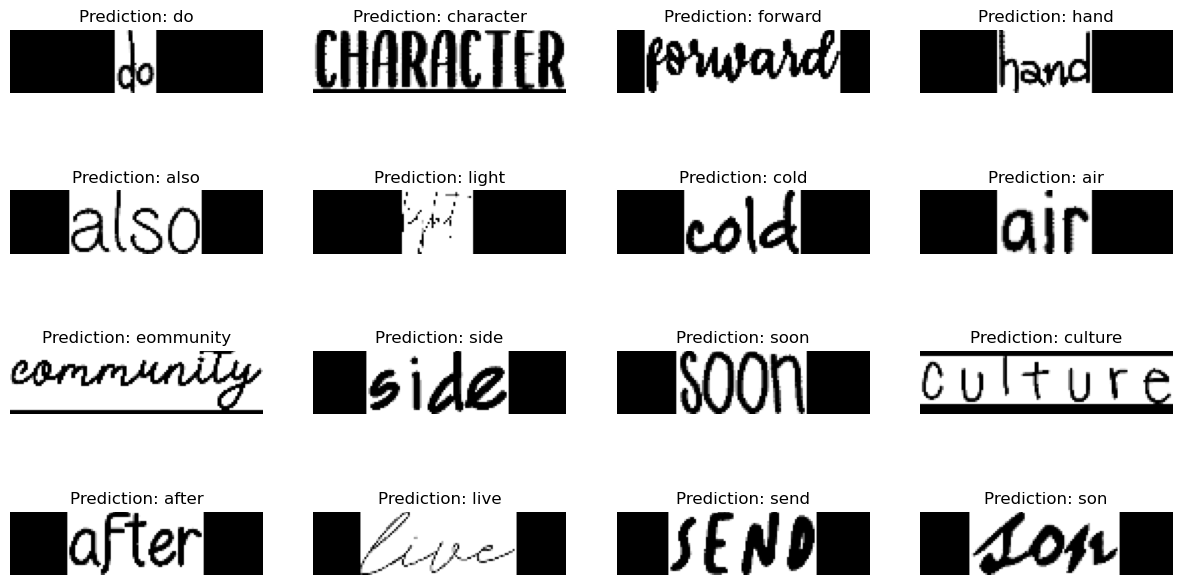

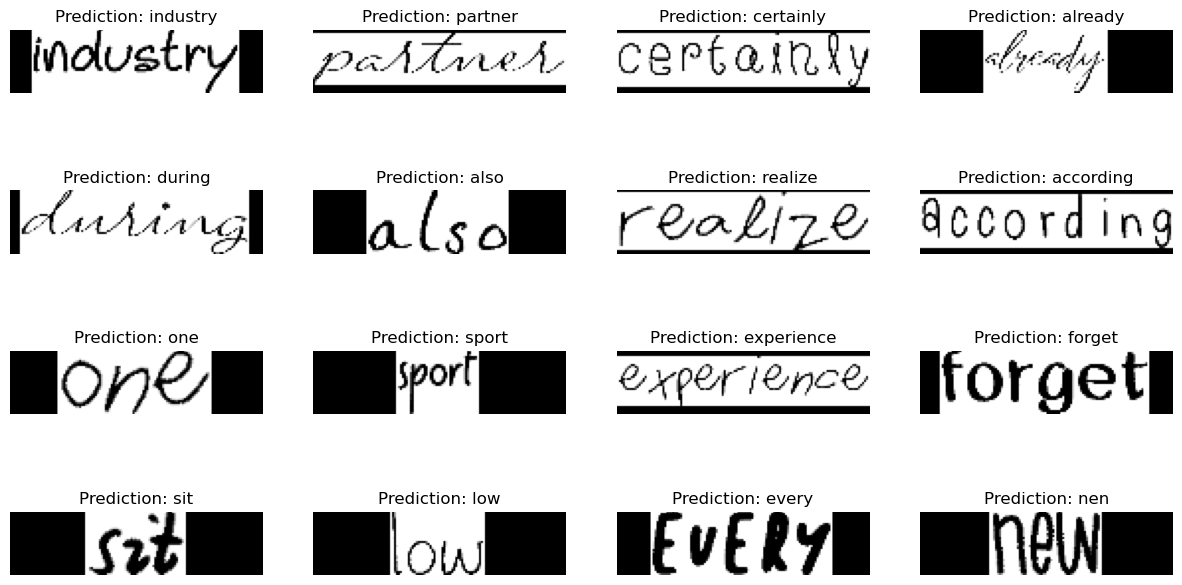

In [42]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For omplex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, 
                                       input_length=input_len, 
                                       greedy=True)[0][0][:, :maxlength]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in train.take(2):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
#         img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

# for downloading the files from kaggle notebook

In [43]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))


In [44]:
download_file('/kaggle/working', 'out')


/kaggle/working/out.zip